In [2]:
# imports

import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Hallways Environment

""" Four rooms. The goal is either in the 3rd room, or in a hallway adjacent to it
"""

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

NUM_ROOMS = 4

class FourRooms(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, g):
        self.room_sizes = [[5,5], [6,5], [4,5], [5,5]]
        self.pre_hallways = [ # pre_hallways[pre hallway box] = [Action, Resulting hallway_coords index]
                                { tuple([2,4]) : [RIGHT, 0], tuple([4,1]) : [DOWN, 3]},
                                { tuple([2,0]) : [LEFT, 0], tuple([5,2]) : [DOWN, 1]},
                                { tuple([0,2]) : [UP, 1], tuple([2,0]) : [LEFT, 2]},
                                { tuple([3,4]) : [RIGHT, 2], tuple([0,1]) : [UP, 3]},
                            ]
        self.hallway_coords = [ [2,5], [6,2], [2,-1], [-1,1] ]
        self.hallways = [ #self.hallways[i][j] = [next_room, next_coord] when taking action j from hallway i#
                            [ [0, self.hallway_coords[0]], [1, [2,0]], [0, self.hallway_coords[0]], [0, [2,4]] ],
                            [ [1, [5,2]], [1, self.hallway_coords[1]], [2, [0,2]], [1, self.hallway_coords[1]] ],
                            [ [2, self.hallway_coords[2]], [2, [2,0]], [2, self.hallway_coords[2]], [3, [3,4]] ],
                            [ [0, [4,1]], [3, self.hallway_coords[3]], [3, [0,1]], [3, self.hallway_coords[3]] ]
                        ]
        self.offsets = [0] * (NUM_ROOMS + 1)
        for i in range(NUM_ROOMS):
            self.offsets[i + 1] = self.offsets[i] + self.room_sizes[i][0] * self.room_sizes[i][1] + 1
        self.n_states = self.offsets[4] + 1
        self.absorbing_state = self.n_states-1 # one extra state added in above line

        self.goal2 = [2, [1, 2]] 
        self.goal1 = [1, [6, 2]]
        self.goals = [self.goal1, self.goal2]
        self.g = g
        self.terminal_state = self.encode(self.goals[self.g-1])

        self.noise = 0.44 # 0.44 (4/9) for his way -> 0.33 in gen
        self.step_reward = 0.0
        self.terminal_reward = 1.0
        self.bump_reward = 0 

        # start state random location in start room
        start_room = 0
        sz = self.room_sizes[start_room]
        self.start_state = self.offsets[start_room] + np.random.randint(sz[0]*sz[1] - 1)
        # self.start_state = self.encode([3,[2,2]])
        self._reset()

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(self.n_states) # with absorbing state


    def ind2coord(self, index, sizes=None):
        if sizes is None:
            sizes = [self.n]*2 # what is self.n ?
        [rows, cols] = sizes

        assert(index >= 0)

        row = index // cols
        col = index % cols

        return [row, col]


    def coord2ind(self, coord, sizes=None):
        if sizes is None:
            sizes = [self.n]*2

        [rows, cols] = sizes
        [row, col] = coord

        assert(row < rows)
        assert(col < cols)

        return row * cols + col

    def in_hallway_index(self, index=None): # is_in_the_hallway?
        if index is None:
            index = self.state
        return index in [offset - 1 for offset in self.offsets]

    def in_hallway_coord(self, coord):
        return coord in self.hallway_coords

    def encode(self, location, in_hallway=None):
        [room, coord] = location
        if in_hallway is None:
            in_hallway = self.in_hallway_coord(coord)

        if in_hallway:
            return self.offsets[room + 1] - 1
            # maybe have hallways as input
        ind_in_room = self.coord2ind(coord, sizes=self.room_sizes[room])
        return ind_in_room + self.offsets[room]

    def decode(self, index, in_hallway=None):
        if in_hallway is None:
            in_hallway = self.in_hallway_index(index=index)

        room = [r for r, offset in enumerate(self.offsets[1:5]) if index < offset][0]
        if in_hallway:
            coord_in_room = self.hallway_coords[room]
        else:
            coord_in_room = self.ind2coord(index - self.offsets[room], sizes=self.room_sizes[room])
        return room, coord_in_room # hallway

    def _step(self, action):
        assert self.action_space.contains(action)
        
        if self.state == self.terminal_state:
            self.done = True
            self.state = self.absorbing_state
            return self.state, self.terminal_reward, True, None

        in_hallway = self.in_hallway_index()
        [room, coord]= self.decode(self.state, in_hallway=in_hallway)
        room2 = room; coord2 = coord

        if np.random.rand() < self.noise:
            action = self.action_space.sample()

        if in_hallway: # hallway action
            [room2, coord2] = self.hallways[room][action]

        elif (tuple(coord) in self.pre_hallways[room].keys()) and (action == self.pre_hallways[room][tuple(coord)][0]):
            room2 = self.pre_hallways[room][tuple(coord)][1]
            coord2 = self.hallway_coords[room2]
        else: # normal action
            [row, col] = coord
            [rows, cols] = self.room_sizes[room]
            if action == UP:
                row = max(row - 1, 0)
            elif action == DOWN:
                row = min(row + 1, rows - 1)
            elif action == RIGHT:
                col = min(col + 1, cols - 1)
            elif action == LEFT:
                col = max(col - 1, 0)
            coord2 = [row, col]

        new_state = self.encode([room2, coord2])
        reward = self._get_reward(new_state)
        self.state = new_state

        return new_state, reward, self.done, None

    def _get_reward(self, new_state=None):
        if self.done:
            return self.terminal_reward

        reward = self.step_reward

        if self.bump_reward != 0 and self.state == new_state:
            reward = self.bump_reward

        return reward

    def at_border(self):
        [row, col] = self.ind2coord(self.state)
        return (row == 0 or row == self.n - 1 or col == 0 or col == self.n - 1)


    def _reset(self):
        self.state = self.start_state if not isinstance(self.start_state, str) else np.random.randint(self.n_states - 1)
        # self.state = self.encode([3,[2,2]])
        self.done = False
        return self.state

    def _render(self, mode='human', close=False):
        pass

In [4]:
# Testing with random trails

env0 = FourRooms(1)
env0._reset()
print(env0.action_space, env0.observation_space, env0.start_state)
print(env0.terminal_state)
for i in range(10000):
    new_state, rwd, done, _ = env0._step(rd.choice([0,1,2,3]))
    if done :
        print("steps: "+str(i+1))
        print("Completed <-> Eureka")
        break
    print(env0.decode(new_state), rwd)
    # print(new_state)
        

Discrete(4) Discrete(105) 10
56
(0, [3, 0]) 0.0
(0, [3, 1]) 0.0
(0, [3, 0]) 0.0
(0, [3, 1]) 0.0
(0, [3, 0]) 0.0
(0, [3, 0]) 0.0
(0, [4, 0]) 0.0
(0, [3, 0]) 0.0
(0, [3, 0]) 0.0
(0, [4, 0]) 0.0
(0, [4, 1]) 0.0
(0, [3, 1]) 0.0
(0, [3, 0]) 0.0
(0, [3, 1]) 0.0
(0, [3, 2]) 0.0
(0, [4, 2]) 0.0
(0, [3, 2]) 0.0
(0, [2, 2]) 0.0
(0, [2, 1]) 0.0
(0, [2, 2]) 0.0
(0, [2, 3]) 0.0
(0, [1, 3]) 0.0
(0, [0, 3]) 0.0
(0, [0, 2]) 0.0
(0, [0, 2]) 0.0
(0, [1, 2]) 0.0
(0, [0, 2]) 0.0
(0, [0, 3]) 0.0
(0, [1, 3]) 0.0
(0, [2, 3]) 0.0
(0, [1, 3]) 0.0
(0, [1, 4]) 0.0
(0, [1, 3]) 0.0
(0, [1, 2]) 0.0
(0, [2, 2]) 0.0
(0, [3, 2]) 0.0
(0, [3, 1]) 0.0
(0, [3, 0]) 0.0
(0, [2, 0]) 0.0
(0, [2, 1]) 0.0
(0, [2, 0]) 0.0
(0, [2, 1]) 0.0
(0, [2, 0]) 0.0
(0, [2, 0]) 0.0
(0, [2, 0]) 0.0
(0, [2, 1]) 0.0
(0, [2, 2]) 0.0
(0, [2, 1]) 0.0
(0, [2, 2]) 0.0
(0, [2, 1]) 0.0
(0, [1, 1]) 0.0
(0, [1, 0]) 0.0
(0, [2, 0]) 0.0
(0, [2, 0]) 0.0
(0, [2, 0]) 0.0
(0, [3, 0]) 0.0
(0, [2, 0]) 0.0
(0, [1, 0]) 0.0
(0, [0, 0]) 0.0
(0, [1, 0]) 0.0
(0, [0, 

    1. β maps the terminal state to 1 in all options
    2. option is defined by -> I,π,β
    3. probability that an option terminates is 1 in our set of options
    4. gamma = 0.9, eps = 0.1 and alf = 0.125
    DS:
    Q[state][option] -> val func
    T[option] -> terminal state of the option -> single terminal state
    Pi[state][option] -> policy of the option -> action number
    O[state] -> list of available actions -> equivalent I or initial state set of options
    

In [5]:
# Programming Options

env = FourRooms(1)
T = [25,103,56,25,77,56,103,77] # terminal state for each options
O = [[] for i in range(env.n_states)] # initiation state set for options 
for i in range(25):
    O[i].append(0)
    O[i].append(1)
for i in range(26,56):
    O[i].append(2)
    O[i].append(3)
for i in range(57,77):
    O[i].append(4)
    O[i].append(5)
for i in range(78,103):
    O[i].append(6)
    O[i].append(7)
O[77].append(6)
O[77].append(5)
O[25].append(1)
O[25].append(2)
O[56].append(3)
O[56].append(4)
O[103].append(0)
O[103].append(7)

Pi = {} # Policy for options
litral_ends = [[2,5],[5,1],[6,2],[2,-1],[2,-1],[-1,2],[-1,1],[3,5]]
opp_options = [1,0,3,2,5,4,7,6]
for i in range(env.n_states-1):
    for j in O[i]:
        if i == 25 or i == 77 or i == 103 or i == 56:
            b = litral_ends[opp_options[j]]
        else:
            a,b = env.decode(i)
        if b[0] > litral_ends[j][0]:
            Pi[i,j] = UP
        elif b[0] < litral_ends[j][0]:
            Pi[i,j] = DOWN
        elif b[1] > litral_ends[j][1]:
            Pi[i,j] = LEFT
        elif b[1] < litral_ends[j][1]:
            Pi[i,j] = RIGHT
Pi[25,1] = 3
Pi[25,2] = 1
Pi[77,6] = 3
Pi[77,5] = 1

In [64]:
# SMDP Q learning

EPS = 0.1
ALFA = 0.25
GAMMA = 0.9

num_episodes = 10000
t = 100

var_Q = []
var_steps = []
var_srwd = []

envQ = FourRooms(2) # change to alter between G1 and G2

for ir in range(t):
    num_steps = []
    step_rwd = []
    Q = {}
    # initialization
    for st in range(envQ.n_states-1): # first four are primitive actions
        for act in range(4):
            Q[st,act] = 0
        for opt in O[st]: # after that are options
            Q[st,4+opt] = 0

    for i in range(1,num_episodes+1):

        over = False
        ep_rwd = 0
        steps = 0
        pos = envQ._reset()
        act_space = [0,1,2,3] + [O[pos][0]+4,O[pos][1]+4]

        while True:
            # epsilon greedy pick of action
            if(rd.random() > EPS):
                vals = np.array([Q[pos,a] for a in act_space])
                act = act_space[np.argmax(vals)]
                if(Q[pos,act] == 0):
                    act = rd.choice(act_space)   
            else:
                act = rd.choice(act_space)
            if act > 3:
                opt = act - 4
                rt = 0
                k = 0
                g = 1
                p = pos
                while p != T[opt] and (opt in O[p]) and (not over):
                    a = Pi[p,opt]
                    new_pos, rwd, over, _ = envQ._step(a)
                    rt += (g*rwd)
                    k += 1
                    g *= GAMMA
                    p = new_pos
            else:
                new_pos, rwd, over, _ = envQ._step(act)
                rt = rwd
                k = 1
                g = GAMMA
            if over:
                Q[pos,act] = Q[pos,act] + ALFA*(rt - Q[pos,act])
                break
            new_act_space = [0,1,2,3] + [O[new_pos][0]+4,O[new_pos][1]+4]
            new_vals = np.array([Q[new_pos,a] for a in new_act_space])
            new_act = new_act_space[np.argmax(new_vals)]
            Q[pos,act] = Q[pos,act] + ALFA*(rt + (g)*Q[new_pos,new_act] - Q[pos,act])

            pos = new_pos
            act_space = new_act_space
            steps += k

        if(i%(1000) == 0):
            print('Steps'+str(i)+':'+str(steps))

        num_steps.append(steps)
        step_rwd.append(1.0/steps)
    print(ir)    
    var_steps.append(num_steps)
    var_srwd.append(step_rwd)
    var_Q.append(Q)

Steps1000:35
Steps2000:106
Steps3000:15
Steps4000:90
Steps5000:14
Steps6000:8
Steps7000:29
Steps8000:61
Steps9000:14
Steps10000:19
0
Steps1000:34
Steps2000:20
Steps3000:22
Steps4000:22
Steps5000:16
Steps6000:14
Steps7000:18
Steps8000:9
Steps9000:12
Steps10000:10
1
Steps1000:71
Steps2000:20
Steps3000:60
Steps4000:14
Steps5000:12
Steps6000:13
Steps7000:65
Steps8000:13
Steps9000:13
Steps10000:23
2
Steps1000:10
Steps2000:10
Steps3000:15
Steps4000:34
Steps5000:15
Steps6000:195
Steps7000:14
Steps8000:15
Steps9000:53
Steps10000:68
3
Steps1000:15
Steps2000:9
Steps3000:21
Steps4000:10
Steps5000:13
Steps6000:27
Steps7000:8
Steps8000:17
Steps9000:36
Steps10000:14
4
Steps1000:26
Steps2000:59
Steps3000:20
Steps4000:9
Steps5000:15
Steps6000:14
Steps7000:10
Steps8000:14
Steps9000:51
Steps10000:20
5
Steps1000:16
Steps2000:19
Steps3000:34
Steps4000:11
Steps5000:21
Steps6000:16
Steps7000:12
Steps8000:27
Steps9000:23
Steps10000:11
6
Steps1000:10
Steps2000:20
Steps3000:45
Steps4000:20
Steps5000:12
Steps60

Steps5000:24
Steps6000:15
Steps7000:39
Steps8000:26
Steps9000:21
Steps10000:12
61
Steps1000:12
Steps2000:19
Steps3000:106
Steps4000:146
Steps5000:44
Steps6000:12
Steps7000:15
Steps8000:17
Steps9000:20
Steps10000:24
62
Steps1000:11
Steps2000:135
Steps3000:15
Steps4000:16
Steps5000:17
Steps6000:10
Steps7000:18
Steps8000:40
Steps9000:11
Steps10000:12
63
Steps1000:35
Steps2000:153
Steps3000:16
Steps4000:27
Steps5000:8
Steps6000:17
Steps7000:201
Steps8000:23
Steps9000:10
Steps10000:12
64
Steps1000:21
Steps2000:26
Steps3000:170
Steps4000:12
Steps5000:23
Steps6000:17
Steps7000:15
Steps8000:35
Steps9000:12
Steps10000:15
65
Steps1000:10
Steps2000:32
Steps3000:16
Steps4000:13
Steps5000:18
Steps6000:12
Steps7000:36
Steps8000:10
Steps9000:19
Steps10000:26
66
Steps1000:10
Steps2000:67
Steps3000:14
Steps4000:20
Steps5000:8
Steps6000:8
Steps7000:22
Steps8000:107
Steps9000:42
Steps10000:20
67
Steps1000:10
Steps2000:16
Steps3000:15
Steps4000:11
Steps5000:24
Steps6000:118
Steps7000:32
Steps8000:20
Steps

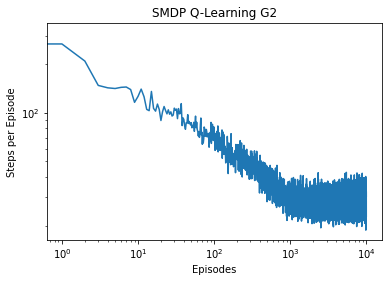

In [65]:
fin_steps = np.mean(var_steps,axis=0)
plt.plot(fin_steps)
plt.xlabel('Episodes')
plt.ylabel('Steps per Episode')
plt.title('SMDP Q-Learning G'+str(envQ.g))
plt.yscale('log')
plt.xscale('log')
plt.show()

In [66]:
fin_Q = {}
for i in range(envQ.n_states-1):
    for j in range(4):
        tot = 0
        for q in var_Q:
            tot += q[i,j]
        fin_Q[i,j] = tot/t
    for j in O[i]:
        tot = 0
        for q in var_Q:
            tot += q[i,j+4]
        fin_Q[i,j+4] = tot/t

In [67]:
offset = {0:[0,0],1:[0,6],3:[6,0],2:[7,6]}
v_grid = np.zeros((11,11))
a_grid = np.zeros((11,11))
for i in range(envQ.n_states-1):
    a,b = envQ.decode(i)
    act_space = [0,1,2,3] + [O[i][0]+4,O[i][1]+4]
    vals = np.array([fin_Q[i,a] for a in act_space])
    act = act_space[np.argmax(vals)]
    if act > 3:
        a_grid[offset[a][0]+b[0]][offset[a][1]+b[1]] = Pi[i,act-4]
    else:
        a_grid[offset[a][0]+b[0]][offset[a][1]+b[1]] = act
    v_grid[offset[a][0]+b[0]][offset[a][1]+b[1]] = fin_Q[i,act]

In [10]:
mask = np.array([[False]*11 for i in range(11)])
for i in range(11):
    mask[i][5] = True
for i in range(6):
    mask[5][i] = True
for i in range(6,11):
    mask[6][i] = True
mask[2][5] = False
mask[5][1] = False
mask[6][8] = False
mask[9][5] = False

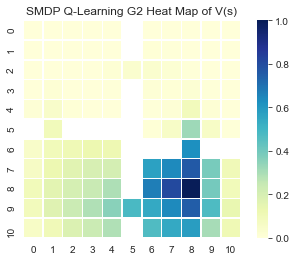

In [69]:
with sns.axes_style("white"):
    ax = sns.heatmap(v_grid, mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
    plt.title('SMDP Q-Learning G'+str(envQ.g)+' Heat Map of V(s)')
    plt.show()

In [44]:

q_grids = [np.zeros((11,11)) for i in range(12)]
for j in range(envQ.n_states-1):
    a,b = envQ.decode(j)
    for i in [0,1,2,3]:
        q_grids[i][offset[a][0]+b[0]][offset[a][1]+b[1]] = fin_Q[j,i]
    for i in O[j]:
        q_grids[i+4][offset[a][0]+b[0]][offset[a][1]+b[1]] = fin_Q[j,i+4]

In [ ]:
act_map = {0:'UP',1:'RIGHT',2:'DOWN',3:'LEFT'}
for i in range(12):
    if i > 3:
        a = 'O'+str(i-4)
    else:
        a = act_map[i]
    with sns.axes_style("white"):
        ax = sns.heatmap(q_grids[i], mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
        plt.title('SMDP Q-Learning G'+str(envQ.g)+' Heat Map of Q(s,'+a+')')
        plt.show()

In [6]:
# Intra Option Q learning

EPS = 0.1
ALFA = 0.25
GAMMA = 0.9

num_episodes = 10000
t = 100

var_Q = []
var_steps = []
var_srwd = []

envQ = FourRooms(2) # change to alter between G1 and G2

for ir in range(t):
    num_steps = []
    step_rwd = []
    Q = {}
    # initialization
    for st in range(envQ.n_states-1): # first four are primitive actions
        for act in range(4):
            Q[st,act] = 0
        for opt in O[st]: # after that are options
            Q[st,4+opt] = 0

    for i in range(1,num_episodes+1):

        over = False
        ep_rwd = 0
        steps = 0
        pos = envQ._reset()
        act_space = [0,1,2,3] + [O[pos][0]+4,O[pos][1]+4]

        while True:
            # epsilon greedy pick of action
            if(rd.random() > EPS):
                vals = np.array([Q[pos,a] for a in act_space])
                act = act_space[np.argmax(vals)]
                if(Q[pos,act] == 0):
                    act = rd.choice(act_space)   
            else:
                act = rd.choice(act_space)
            if act > 3: 
                opt = act - 4
                a = Pi[pos,opt]
                new_pos, rwd, over, _ = envQ._step(a)
                if over:
                    Q[pos,act] = Q[pos,act] + ALFA*(rwd - Q[pos,act])
                    break
                if T[opt] == new_pos or (opt not in O[new_pos]): # if and else is doing deterministic beta work 
                    new_act_space = [0,1,2,3] + [O[new_pos][0]+4,O[new_pos][1]+4]
                    new_vals = np.array([Q[new_pos,a] for a in new_act_space])
                    new_act = new_act_space[np.argmax(new_vals)]
                    Q[pos,act] = Q[pos,act] + ALFA*(rwd + (GAMMA)*Q[new_pos,new_act] - Q[pos,act])
                else:
                    new_act_space = [0,1,2,3] + [O[new_pos][0]+4,O[new_pos][1]+4]
                    for o in O[pos]: # s and pi matches, updating more than one options
                        if a == Pi[pos,o] and o in O[new_pos]:
                            Q[pos,o+4] = Q[pos,o+4] + ALFA*(rwd + (GAMMA)*Q[new_pos,o+4] - Q[pos,o+4])
                
            else:
                new_pos, rwd, over, _ = envQ._step(act)
                if over:
                    Q[pos,act] = Q[pos,act] + ALFA*(rwd - Q[pos,act])
                    break
                new_act_space = [0,1,2,3] + [O[new_pos][0]+4,O[new_pos][1]+4]
                new_vals = np.array([Q[new_pos,a] for a in new_act_space])
                new_act = new_act_space[np.argmax(new_vals)]
                Q[pos,act] = Q[pos,act] + ALFA*(rwd + (GAMMA)*Q[new_pos,new_act] - Q[pos,act])
                for o in O[pos]: # s and pi matches, updating more than one options
                    if act == Pi[pos,o] and o in O[new_pos]:
                        Q[pos,o+4] = Q[pos,o+4] + ALFA*(rwd + (GAMMA)*Q[new_pos,o+4] - Q[pos,o+4])

            pos = new_pos
            act_space = new_act_space
            steps += 1

        if(i%(1000) == 0):
            print('Steps'+str(i)+':'+str(steps))

        num_steps.append(steps)
        step_rwd.append(1.0/steps)
    print(ir)    
    var_steps.append(num_steps)
    var_srwd.append(step_rwd)
    var_Q.append(Q)

Steps1000:37
Steps2000:26
Steps3000:19
Steps4000:35
Steps5000:20
Steps6000:18
Steps7000:42
Steps8000:23
Steps9000:24
Steps10000:30
0
Steps1000:63
Steps2000:18
Steps3000:25
Steps4000:27
Steps5000:43
Steps6000:26
Steps7000:25
Steps8000:32
Steps9000:34
Steps10000:22
1
Steps1000:29
Steps2000:30
Steps3000:31
Steps4000:23
Steps5000:30
Steps6000:33
Steps7000:22
Steps8000:19
Steps9000:23
Steps10000:26
2
Steps1000:23
Steps2000:25
Steps3000:25
Steps4000:22
Steps5000:29
Steps6000:28
Steps7000:22
Steps8000:15
Steps9000:25
Steps10000:42
3
Steps1000:16
Steps2000:25
Steps3000:24
Steps4000:60
Steps5000:25
Steps6000:27
Steps7000:21
Steps8000:21
Steps9000:43
Steps10000:39
4
Steps1000:21
Steps2000:39
Steps3000:31
Steps4000:31
Steps5000:21
Steps6000:35
Steps7000:44
Steps8000:39
Steps9000:40
Steps10000:48
5
Steps1000:56
Steps2000:73
Steps3000:37
Steps4000:23
Steps5000:18
Steps6000:60
Steps7000:34
Steps8000:31
Steps9000:21
Steps10000:19
6
Steps1000:18
Steps2000:27
Steps3000:22
Steps4000:32
Steps5000:29
Step

Steps4000:28
Steps5000:55
Steps6000:30
Steps7000:25
Steps8000:22
Steps9000:20
Steps10000:17
61
Steps1000:56
Steps2000:42
Steps3000:56
Steps4000:75
Steps5000:44
Steps6000:51
Steps7000:18
Steps8000:68
Steps9000:27
Steps10000:27
62
Steps1000:56
Steps2000:26
Steps3000:46
Steps4000:18
Steps5000:17
Steps6000:29
Steps7000:27
Steps8000:31
Steps9000:32
Steps10000:33
63
Steps1000:49
Steps2000:30
Steps3000:35
Steps4000:54
Steps5000:49
Steps6000:29
Steps7000:25
Steps8000:48
Steps9000:31
Steps10000:27
64
Steps1000:17
Steps2000:40
Steps3000:17
Steps4000:26
Steps5000:59
Steps6000:38
Steps7000:37
Steps8000:15
Steps9000:20
Steps10000:18
65
Steps1000:39
Steps2000:27
Steps3000:30
Steps4000:23
Steps5000:24
Steps6000:25
Steps7000:27
Steps8000:31
Steps9000:36
Steps10000:37
66
Steps1000:21
Steps2000:27
Steps3000:17
Steps4000:27
Steps5000:24
Steps6000:38
Steps7000:28
Steps8000:30
Steps9000:17
Steps10000:22
67
Steps1000:28
Steps2000:23
Steps3000:19
Steps4000:18
Steps5000:22
Steps6000:16
Steps7000:48
Steps8000:

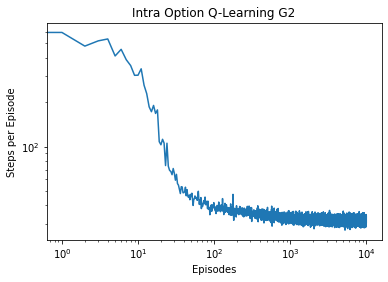

In [7]:
fin_steps = np.mean(var_steps,axis=0)
plt.plot(fin_steps)
plt.xlabel('Episodes')
plt.ylabel('Steps per Episode')
plt.title('Intra Option Q-Learning G'+str(envQ.g))
plt.yscale('log')
plt.xscale('log')
plt.show()

In [8]:
fin_Q = {}
for i in range(envQ.n_states-1):
    for j in range(4):
        tot = 0
        for q in var_Q:
            tot += q[i,j]
        fin_Q[i,j] = tot/t
    for j in O[i]:
        tot = 0
        for q in var_Q:
            tot += q[i,j+4]
        fin_Q[i,j+4] = tot/t

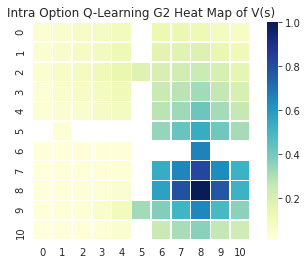

In [11]:
offset = {0:[0,0],1:[0,6],3:[6,0],2:[7,6]}
v_grid = np.zeros((11,11))
a_grid = np.zeros((11,11))
for i in range(envQ.n_states-1):
    a,b = envQ.decode(i)
    act_space = [0,1,2,3] + [O[i][0]+4,O[i][1]+4]
    vals = np.array([fin_Q[i,a] for a in act_space])
    act = act_space[np.argmax(vals)]
    if act > 3:
        a_grid[offset[a][0]+b[0]][offset[a][1]+b[1]] = Pi[i,act-4]
    else:
        a_grid[offset[a][0]+b[0]][offset[a][1]+b[1]] = act
    v_grid[offset[a][0]+b[0]][offset[a][1]+b[1]] = fin_Q[i,act]
    

with sns.axes_style("white"):
    ax = sns.heatmap(v_grid, mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
    plt.title('Intra Option Q-Learning G'+str(envQ.g)+' Heat Map of V(s)')
    plt.show()

In [12]:
q_grids = [np.zeros((11,11)) for i in range(12)]
for j in range(envQ.n_states-1):
    a,b = envQ.decode(j)
    for i in [0,1,2,3]:
        q_grids[i][offset[a][0]+b[0]][offset[a][1]+b[1]] = fin_Q[j,i]
    for i in O[j]:
        q_grids[i+4][offset[a][0]+b[0]][offset[a][1]+b[1]] = fin_Q[j,i+4]

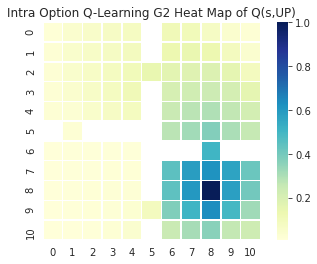

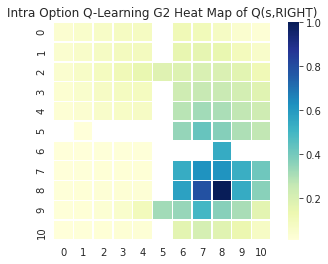

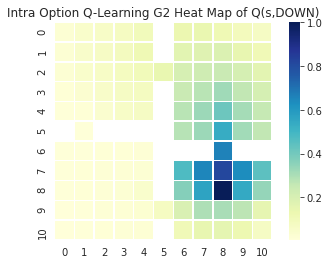

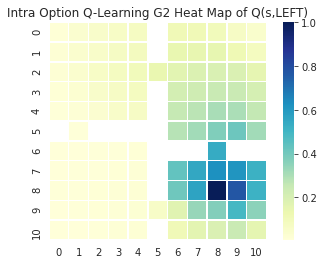

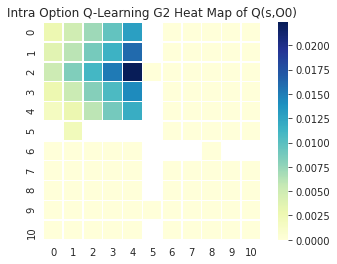

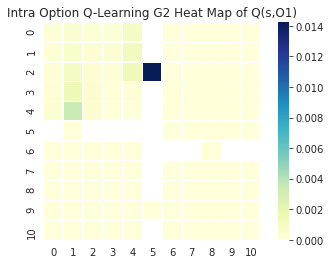

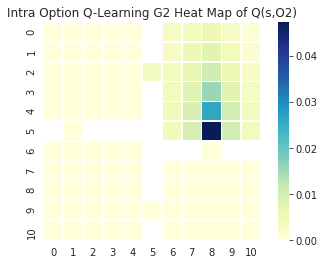

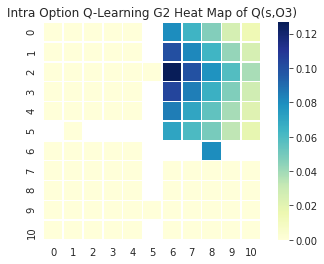

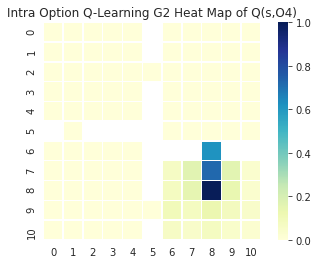

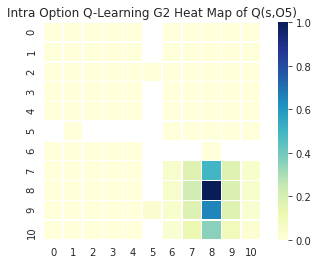

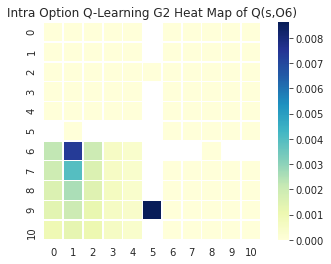

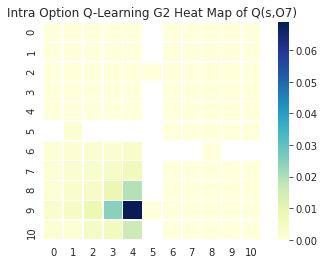

In [13]:
act_map = {0:'UP',1:'RIGHT',2:'DOWN',3:'LEFT'}
for i in range(12):
    if i > 3:
        a = 'O'+str(i-4)
    else:
        a = act_map[i]
    with sns.axes_style("white"):
        ax = sns.heatmap(q_grids[i], mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
        plt.title('Intra Option Q-Learning G'+str(envQ.g)+' Heat Map of Q(s,'+a+')')
        plt.show()

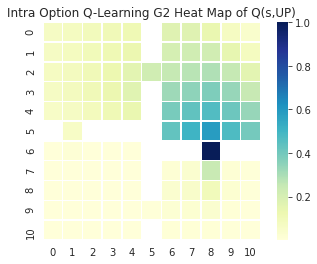

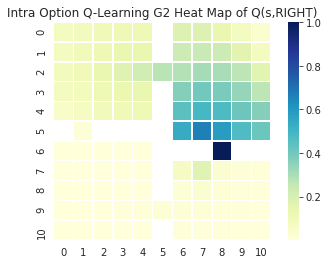

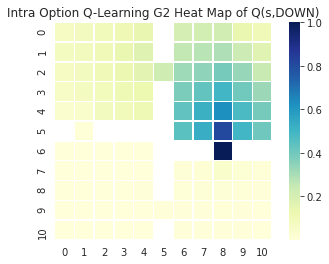

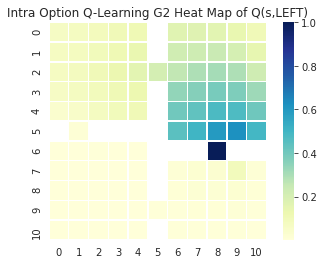

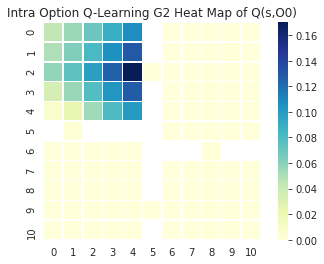

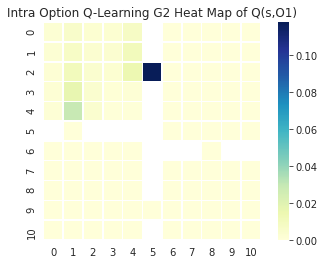

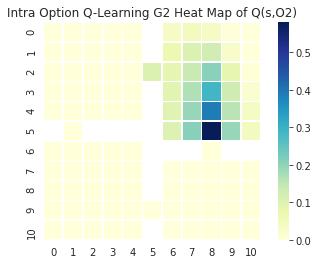

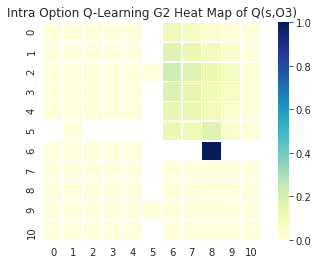

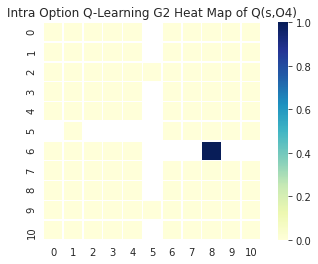

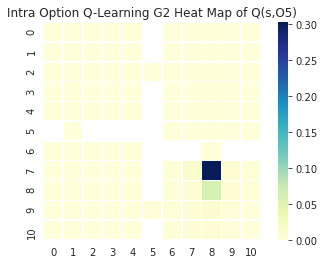

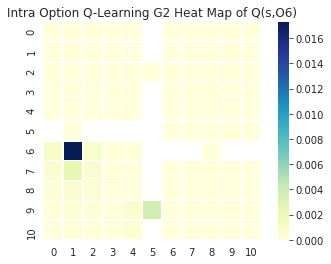

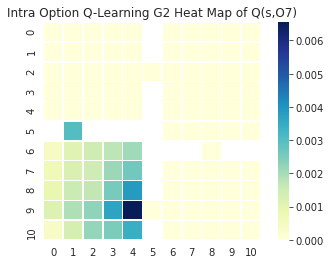

In [29]:
act_map = {0:'UP',1:'RIGHT',2:'DOWN',3:'LEFT'}
for i in range(12):
    if i > 3:
        a = 'O'+str(i-4)
    else:
        a = act_map[i]
    with sns.axes_style("white"):
        ax = sns.heatmap(q_grids[i], mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
        plt.title('Intra Option Q-Learning G'+str(envQ.g)+' Heat Map of Q(s,'+a+')')
        plt.show()

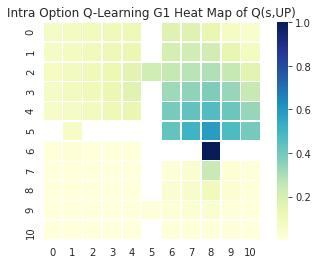

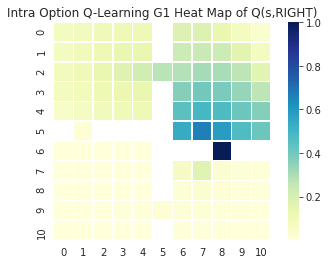

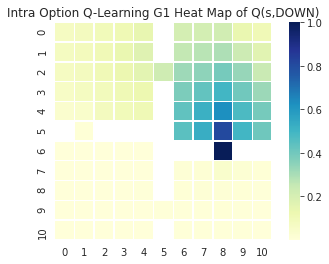

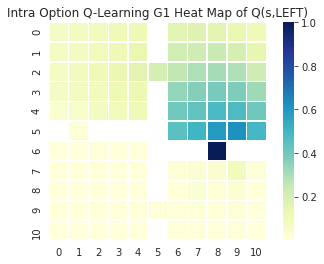

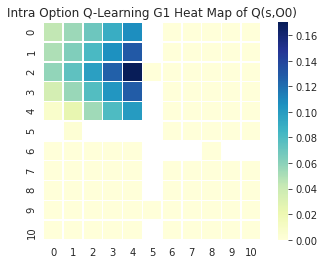

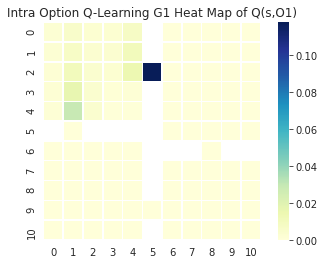

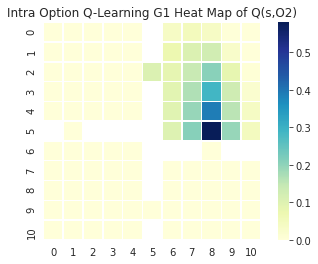

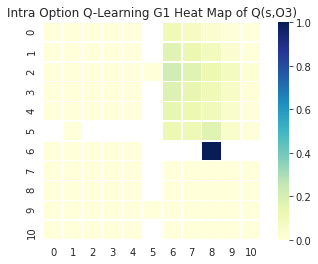

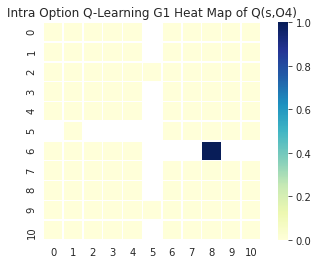

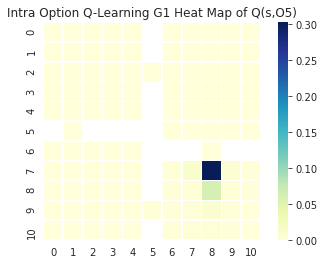

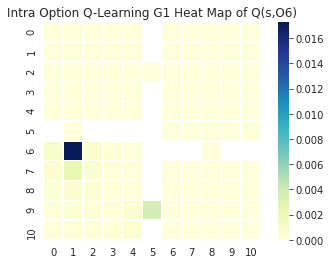

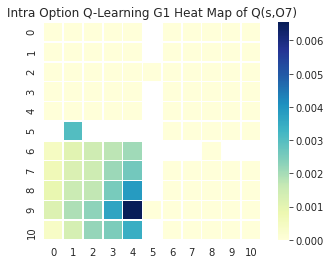

In [24]:
act_map = {0:'UP',1:'RIGHT',2:'DOWN',3:'LEFT'}
for i in range(12):
    if i > 3:
        a = 'O'+str(i-4)
    else:
        a = act_map[i]
    with sns.axes_style("white"):
        ax = sns.heatmap(q_grids[i], mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
        plt.title('Intra Option Q-Learning G'+str(envQ.g)+' Heat Map of Q(s,'+a+')')
        plt.show()

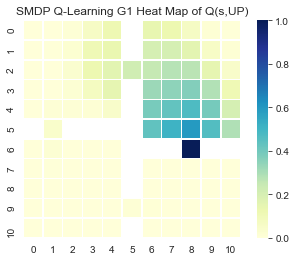

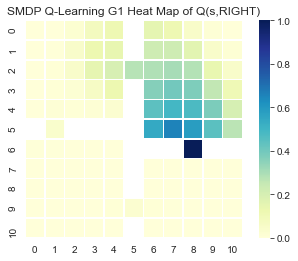

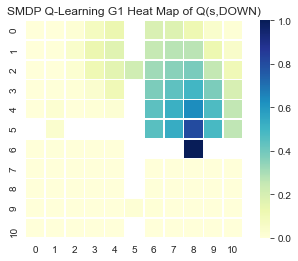

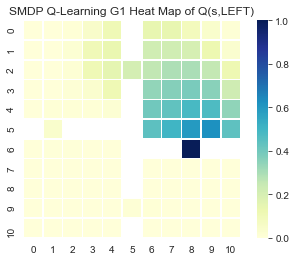

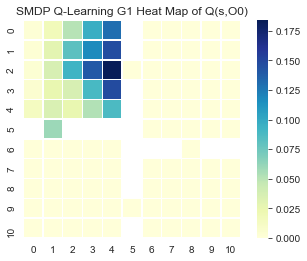

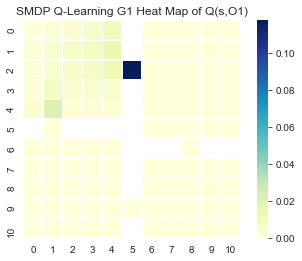

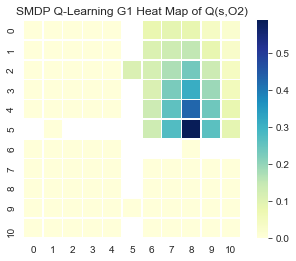

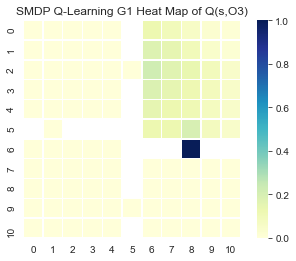

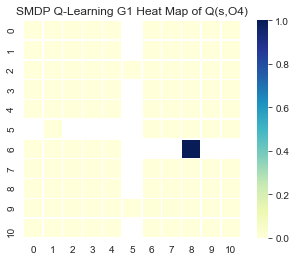

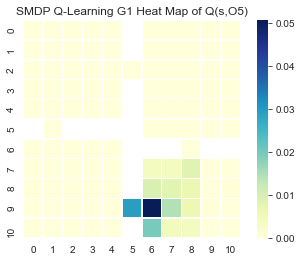

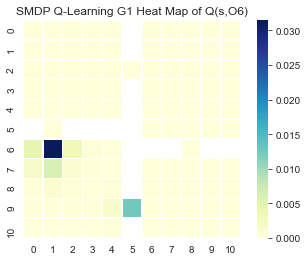

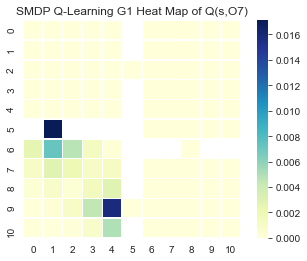

In [45]:
act_map = {0:'UP',1:'RIGHT',2:'DOWN',3:'LEFT'}
for i in range(12):
    if i > 3:
        a = 'O'+str(i-4)
    else:
        a = act_map[i]
    with sns.axes_style("white"):
        ax = sns.heatmap(q_grids[i], mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
        plt.title('SMDP Q-Learning G'+str(envQ.g)+' Heat Map of Q(s,'+a+')')
        plt.show()

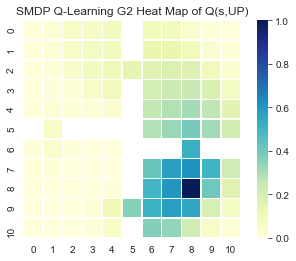

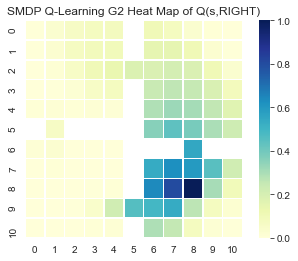

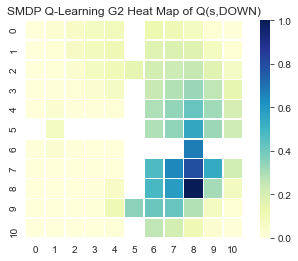

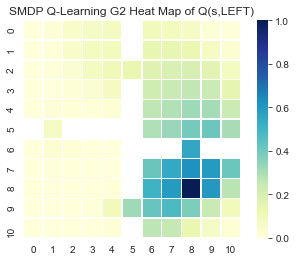

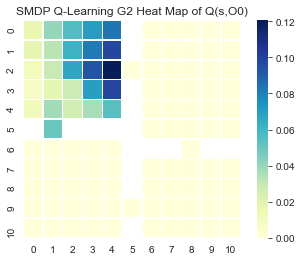

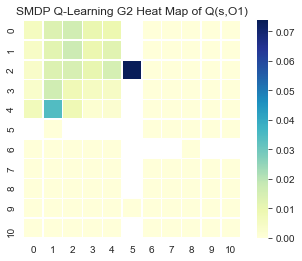

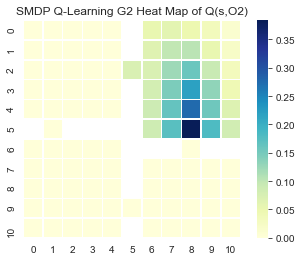

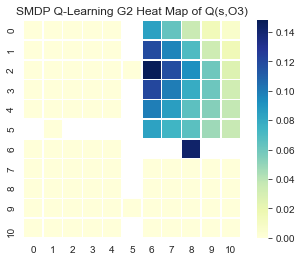

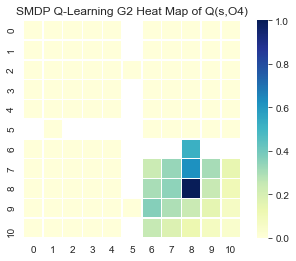

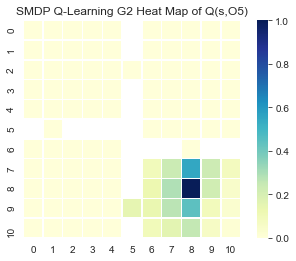

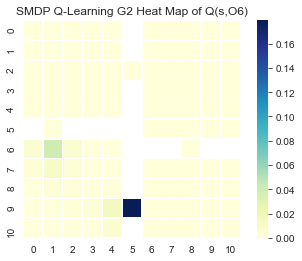

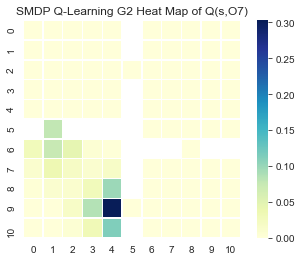

In [37]:
act_map = {0:'UP',1:'RIGHT',2:'DOWN',3:'LEFT'}
for i in range(12):
    if i > 3:
        a = 'O'+str(i-4)
    else:
        a = act_map[i]
    with sns.axes_style("white"):
        ax = sns.heatmap(q_grids[i], mask=mask, square=True,  cmap='YlGnBu', linewidth=0.5)
        plt.title('SMDP Q-Learning G'+str(envQ.g)+' Heat Map of Q(s,'+a+')')
        plt.show()